# RecentCandles Dashboard
 
Contract info can be found here: https://pennies.interactivebrokers.com/cstools/contract_info/v3.10/index.php 

## 3CR Indicator
The recent candlesticks include "3CR" reversal indicators

<img src="./images/3cr-1.png"  width="600" height="300">
<img src="./images/3cr-2.png"  width="600" height="300">
<img src="./images/2breversal.jpg"  width="600" height="300">



## Connect to IB

In [1]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper  
from ibapi.contract import Contract

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mpl_dates

import talib

from datetime import datetime, timezone
from zoneinfo import ZoneInfo

import threading
import time

class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)

    def tickPrice(self, reqId, tickType, price, attrib):
        if tickType == 2 and reqId == 1:
            print(tickType, ': The current ask price is: ', price)
    
    def historicalData(self, reqId, bar):        
        collectData(reqId, bar)

def run_loop():
    ib.run()

ib = IBapi()
ib.connect('host.docker.internal', 7496, 666)

api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()
time.sleep(1)


ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:uscrypto
ERROR -1 2104 Market data farm connection is OK:usfuture.nj
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:ushmds.nj
ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefeu


## Setup data for Dashboard


In [2]:
class ContractWrapper:

    def __init__(self, contract, contractName = None):
        self.contract = contract
        self.data = dict() # data keyed by ReqId
        if contractName is not None:
            self.contractName = contractName
        else:
            self.contractName = (contract.symbol, contract.symbol+'_'+contract.currency)[contract.exchange == 'IDEALPRO']

class Contracts:

    def __init__(self):
        self.contracts = list()
        
    def info(self):
        return f"list of contracts: {self.contracts} "

    def add(self, contractWrapper: ContractWrapper):
        self.contracts.append(contractWrapper)

# Define Contracts
contractsList = Contracts()
def addContract(symbol, secType, exchange, currency, contractMonth = None, contractName = None):
    contract = Contract()
    contract.symbol = symbol
    contract.secType = secType
    contract.exchange = exchange
    contract.currency = currency
    if contractMonth is not None:
        contract.lastTradeDateOrContractMonth = contractMonth
    wrapper = ContractWrapper(contract, contractName)
    contractsList.add(wrapper)

def determine_date_format(date_str):
    #20230407
    formats = ['%Y%m%d', '%Y%m%d %H:%M:%S']
    for fmt in formats:
        try:
            datetime.strptime(date_str, fmt)
            return fmt
        except ValueError:
            pass
    return None

# Define a callback for IB Historical data
def collectData(reqId, bar): 
    for contractItem in contractsList.contracts:
        if reqId in contractItem.data.keys():
            dateFormat = determine_date_format(bar.date)
            #print(f'Date format {dateFormat}')
            seconds = None
            if dateFormat:
                date = datetime.strptime(bar.date, dateFormat)
                seconds = (date - datetime(1970, 1, 1)).total_seconds()
            else:
                seconds = bar.date
            thisCandle = [seconds, bar.open, bar.high, bar.low, bar.close]
            contractItem.data[reqId].append(thisCandle)               

# Find reversals for a specific candleSize dataFrame, e.g. EURUSD 4H candles for  
def find_reversal_points(df): 
    reversal_points = []
    down_reversal_points = []
    # Loop through the DataFrame rows
    minus1Candle = None
    minus1CandleIndex = None
    minus2Candle = None
    minus2CandleIndex = None
    #print(f"No of rows in dataFrame: {len(df)}")
    for index, thisCandle in df.iterrows():
        
        # Check for 2B reversal to the upside
        if minus1Candle is not None and minus2Candle is not None \
            and minus1Candle['Low'] < minus2Candle['Low'] \
            and minus1Candle['High'] < minus2Candle['High'] \
            and thisCandle['Close'] > minus2Candle['High']:
            #print(f"Register 2b reversal: close {thisCandle['Close']} > -2 high {minus2Candle['High']}")
            reversal_points.append(thisCandle['Low'])
        else:
            reversal_points.append(np.nan)
        
        # Check for 2B reversal to the downside
        if minus1Candle is not None and minus2Candle is not None \
            and minus1Candle['Low'] > minus2Candle['Low'] \
            and minus1Candle['High'] > minus2Candle['High'] \
            and thisCandle['Close'] < minus2Candle['Low']:
            down_reversal_points.append(thisCandle['High'])
        else:
            down_reversal_points.append(np.nan)
                
        # Update the previous candles variables for the next iteration
        minus2Candle = minus1Candle
        minus2CandleIndex = minus1CandleIndex

        minus1Candle = thisCandle
        minus1CandleIndex = index

    return reversal_points, down_reversal_points


# Sanitise data ndarray to DataFrame
def to_dataframe(data):
    if not data:
        return None
    
    df = pd.DataFrame(data, columns=['DateTime', 'Open', 'High', 'Low', 'Close'])
    df['DateTime'] = pd.to_datetime(df['DateTime'],unit='s', infer_datetime_format=True)
    df = df.set_index('DateTime')
    
    df['ema10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['ema30'] = df['Close'].ewm(span=30, adjust=False).mean()

    return df

# Sanitise data ndarray to DataFrame, return only last 6 candles
def to_dataframe_last6candles(data):
    if not data:
        return None
    df = to_dataframe(data)
    df = df.tail(6)
    return df


# Initialise Contracts for the Dashboard    
addContract('EUR', 'CASH', 'IDEALPRO', 'USD', contractName='EUR.USD')
"""
addContract('EUR', 'CASH', 'IDEALPRO', 'ZAR', contractName='EUR.ZAR')
addContract('ES', 'FUT', 'CME', 'USD', contractMonth='20230616', contractName='ES Futures')
addContract('MNQ', 'FUT', 'CME', 'USD', contractMonth='20230616', contractName='E-Mini NQ 100')
addContract('YM', 'FUT', 'CBOT', 'USD', contractMonth='20230616', contractName='Dow Jones (YM)')
addContract('BRR', 'FUT', 'CME', 'USD', contractMonth='20230526', contractName='BTC Futures')
addContract('XAUUSD', 'CMDTY', 'SMART', 'USD', contractName='Gold')
addContract('XAGUSD', 'CMDTY', 'SMART', 'USD', contractName='Silver')
#addContract('BTC', 'CRYPTO', 'PAXOS', 'USD')
"""
#print(contractsList.contracts)

"\naddContract('EUR', 'CASH', 'IDEALPRO', 'ZAR', contractName='EUR.ZAR')\naddContract('ES', 'FUT', 'CME', 'USD', contractMonth='20230616', contractName='ES Futures')\naddContract('MNQ', 'FUT', 'CME', 'USD', contractMonth='20230616', contractName='E-Mini NQ 100')\naddContract('YM', 'FUT', 'CBOT', 'USD', contractMonth='20230616', contractName='Dow Jones (YM)')\naddContract('BRR', 'FUT', 'CME', 'USD', contractMonth='20230526', contractName='BTC Futures')\naddContract('XAUUSD', 'CMDTY', 'SMART', 'USD', contractName='Gold')\naddContract('XAGUSD', 'CMDTY', 'SMART', 'USD', contractName='Silver')\n#addContract('BTC', 'CRYPTO', 'PAXOS', 'USD')\n"

## Request IB historical data

In [3]:
timeSpan = '6 W'
candleSizes = ['1 hour']
rId = 0
for contract in contractsList.contracts:
    print(f"Requesting historical data for {contract.contract.symbol}_{contract.contract.currency} ...")
    for candleSize in candleSizes:
        rId = rId + 1
        #print(f"  ReqID {rId} - timeSpan:'{timeSpan}' candleSize:'{candleSize}'")
        contract.data[rId] = list()
        ib.reqHistoricalData(rId, contract.contract, '', timeSpan, candleSize, 'MIDPOINT', 0, 2, False, [])
        #print(f"  ReqID {rId} Done.")
        time.sleep(0.1)
    print(f"Done for {contract.contract.symbol}_{contract.contract.currency} ...")
    print(f"------------------------------------------------------------------------------------------")

#wait for all data to come in
time.sleep(3)

Requesting historical data for EUR_USD ...
Done for EUR_USD ...
------------------------------------------------------------------------------------------


In [24]:
# For each contract
for c in contractsList.contracts:    
    # For each requested candleSize data array. key=reqId, value=contractNDArray
    for reqId,contractDataArray in c.data.items():    
        if contractDataArray:
            contractPriceDataDF = to_dataframe(contractDataArray)
            print(contractPriceDataDF.tail(6))
            print("-------------")
            #resample to weekly
            print("resampled to weekly -------------")
            weeklyDf = contractPriceDataDF.resample('W-MON').last('7D')
            print(weeklyDf)
            
            weekly_open_date = weeklyDf.index[-1]
            weekly_open_price = weeklyDf.iloc[-1]
            print(f'date {weekly_open_date}, price {weekly_open_price}')
            
            print("resampled to ::7 -------------")
            week = contractPriceDataDF.resample('D').interpolate()[::7]
            print(week)
            
            
            
            #resample to daily
            
            #resample to 4h
            
            
            
            

                        Open     High      Low    Close     ema10     ema30
DateTime                                                                   
2023-05-19 14:00:00  1.07955  1.07965  1.07845  1.07860  1.079099  1.079184
2023-05-19 15:00:00  1.07860  1.08270  1.07825  1.08190  1.079608  1.079359
2023-05-19 16:00:00  1.08190  1.08250  1.08115  1.08210  1.080061  1.079536
2023-05-19 17:00:00  1.08210  1.08290  1.08180  1.08195  1.080405  1.079692
2023-05-19 18:00:00  1.08195  1.08205  1.08080  1.08085  1.080486  1.079767
2023-05-19 19:00:00  1.08085  1.08095  1.07975  1.07990  1.080379  1.079775
-------------
resampled to weekly -------------
               Open     High      Low    Close     ema10     ema30
DateTime                                                          
2023-04-10  1.08650  1.08700  1.08640  1.08690  1.086336  1.087703
2023-04-17  1.09240  1.09265  1.09240  1.09245  1.093012  1.095737
2023-04-24  1.10510  1.10575  1.10495  1.10575  1.104130  1.101600
2023-05-0

ERROR -1 2103 Market data farm connection is broken:uscrypto
ERROR -1 2103 Market data farm connection is broken:usfarm.nj
ERROR -1 2103 Market data farm connection is broken:usfuture.nj
ERROR -1 2157 Sec-def data farm connection is broken:secdefeu
ERROR -1 2103 Market data farm connection is broken:usfarm.nj
ERROR -1 2103 Market data farm connection is broken:eufarm
ERROR -1 2105 HMDS data farm connection is broken:euhmds
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2103 Market data farm connection is broken:usfuture.nj
ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfuture.nj
ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2103 Market data farm connection is broken:usfuture.nj
ERROR -1 2104 Market data farm connection is OK:usfuture.nj
ERROR -1 2103 Market data farm conne

## Plot 

## Plot in Grid

EUR.USD [1 week]
weekly_open.last(): DateTime
2023-05-19    1.0854
Name: Open, dtype: float64
weekly_open_price: 1.0854
weekly_open_date: 2023-05-19 00:00:00
EUR.USD [1 day]
weekly_open.last(): DateTime
2023-05-15    1.08540
2023-05-16    1.08745
2023-05-17    1.08640
2023-05-18    1.08400
2023-05-19    1.07705
Name: Open, dtype: float64
weekly_open_price: 1.07705
weekly_open_date: 2023-05-19 00:00:00
EUR.USD [4 hours]
weekly_open.last(): DateTime
2023-05-17 16:00:00    1.08295
2023-05-17 20:00:00    1.08400
2023-05-17 21:15:00    1.08400
2023-05-18 00:00:00    1.08380
2023-05-18 04:00:00    1.08400
2023-05-18 08:00:00    1.08165
2023-05-18 12:00:00    1.08150
2023-05-18 16:00:00    1.07755
2023-05-18 20:00:00    1.07740
2023-05-18 21:15:00    1.07705
2023-05-19 00:00:00    1.07750
2023-05-19 04:00:00    1.07685
2023-05-19 08:00:00    1.07775
2023-05-19 12:00:00    1.08090
2023-05-19 16:00:00    1.08190
Name: Open, dtype: float64
weekly_open_price: 1.0819
weekly_open_date: 2023-05-19 1

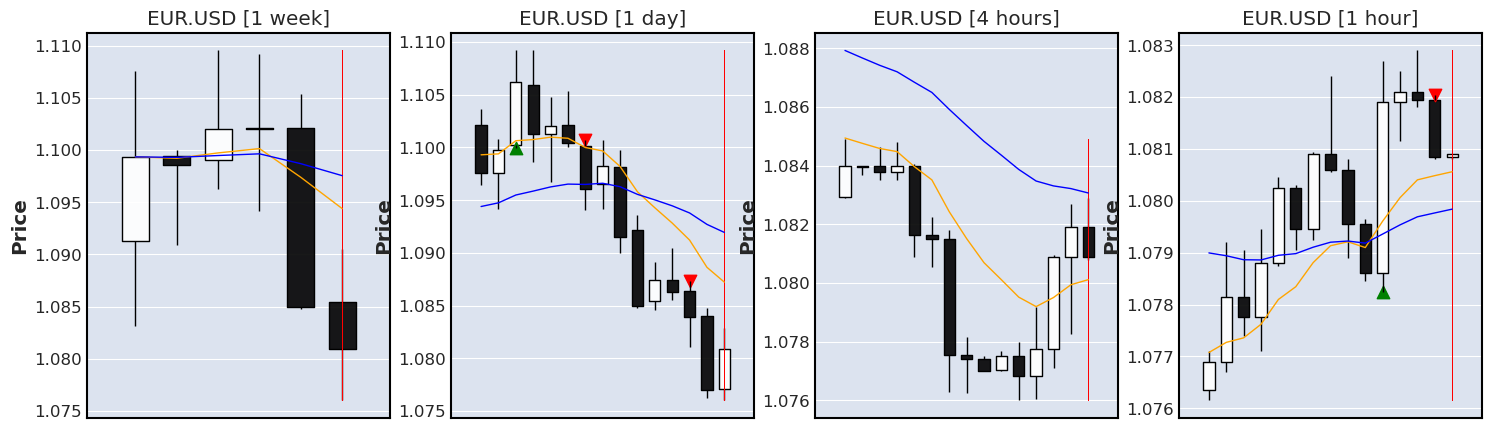

In [20]:
rows = len(contractsList.contracts)
columns = 4
rowHeight = 5
figWidth = 18
figHeight = rowHeight * rows
noOfCandles = 15
fig = mpf.figure(figsize=(figWidth,figHeight))

def get_contract_plus_candle_size(reqId, columns, contractName):
    diff = reqId%columns
    title = contractName
    match diff:
        case 1: # Weekly
            title = f"{c.contractName} [{candleSizes[0]}]"
        case 2: # Daily
            title = f"{c.contractName} [{candleSizes[1]}]"
        case 3: # H4
            title = f"{c.contractName} [{candleSizes[2]}]"
        case 0: # H1
            #print(f"{c.contractName} [{candleSizes[3]}] monthly open price: {current_month_open_price}")
            title = f"{c.contractName} [{candleSizes[3]}]"    
    return title

# For each contract
for c in contractsList.contracts:    
    # For each requested candleSize data array. key=reqId, value=contractNDArray
    for reqId,contractDataArray in c.data.items():    
        if contractDataArray:
            title = get_contract_plus_candle_size(reqId, columns, c.contractName)
            print(f'{title}')
            #contractPriceDataDF = to_dataframe_last6candles(contractDataArray)
            contractPriceDataDF = to_dataframe(contractDataArray)
            
            reversalPoints, downReversalPoints = find_reversal_points(contractPriceDataDF)
            
            contractPriceDataDF = contractPriceDataDF.tail(noOfCandles)
            negNoOfCandles = -noOfCandles
            reversalPoints = reversalPoints[negNoOfCandles:]
            downReversalPoints = downReversalPoints[negNoOfCandles:]
            
            #monthly_open = contractPriceDataDF['Open'].resample('M').last()
            #monthly_open_price = monthly_open.iloc[-1]
            
            weekly_open = contractPriceDataDF['Open'].last('7D')
            print(f'weekly_open.last(): {weekly_open}')
            #weekly_open = contractPriceDataDF['Open'].resample('W').first()
            #print(f'weekly_open.first(): {weekly_open}')
            weekly_open_date = weekly_open.index[-1]
            weekly_open_price = weekly_open.iloc[-1]
            
            
            print(f'weekly_open_price: {weekly_open_price}')
            print(f'weekly_open_date: {weekly_open_date}')
            
            ax1 = fig.add_subplot(rows, columns, reqId)
            ax1.axes.xaxis.set_visible(False)
            #ax1.axes.yaxis.set_visible(False)
            #additionalPlot = mpf.make_addplot(to_dataframe(reversal_points), scatter=True, markersize=100, marker='^', color='red')
            #vls = pd.date_range(df.index.min(), df.index.max(), freq='D').tolist()
            hlines=dict(hlines=(weekly_open_price),colors=['g'],linestyle='dotted',linewidths=(1,1) )
            vlines=dict(vlines=(weekly_open_date), linewidths=0.5, colors=('r'))
            
            #print(f'M open: {monthly_open_price}, W open: {weekly_open_price}')
            #print('-------------------------')
            noReversals = all(np.isnan(item) for item in reversalPoints)
            noDownReversals = all(np.isnan(item) for item in downReversalPoints)
            
            aps=[]
            
            if not noDownReversals:
                aps.append(mpf.make_addplot(downReversalPoints, ax=ax1, type='scatter', marker='v', markersize=80, color='red'))
            if not noReversals:
                aps.append(mpf.make_addplot(reversalPoints, ax=ax1, type='scatter', marker='^', markersize=80, color='green'))
            
            #ema_10 = talib.EMA(contractPriceDataDF['Close'], timeperiod=10)
            #print(type(ema_10))
            aps.append(mpf.make_addplot(contractPriceDataDF['ema10'], ax=ax1, color='orange', width=1))
            aps.append(mpf.make_addplot(contractPriceDataDF['ema30'], ax=ax1, color='blue', width=1))
            
            # Add the vertical lines using make_addplot and vlines
            #vertical_lines = [weekly_open_date]
            #vline_ap = mpf.make_addplot([], panel=0, secondary_y=False)
            #ax1.add_collection(vline_ap.mpl)
            #for line in vertical_lines:
            #    x = contractPriceDataDF.index.get_loc(line)
            #    ax1.vlines(x, ymin=mpf.scaled(contractPriceDataDF, 0.98).min(), ymax=mpf.scaled(df, 1.02).max(), color='grey', linestyle='--')


            #mpf.plot(contractPriceDataDF, ax=ax1, addplot=aps, hlines=hlines, type='candle', axtitle=title)
            mpf.plot(contractPriceDataDF, ax=ax1, addplot=aps, vlines=vlines, type='candle', axtitle=title)
            
            #ax1.axhline(weekly_open_price, color='red', linestyle='--')
            #ax1.annotate('Price: {}'.format(weekly_open_price),
            #     xy=(weekly_open_date, weekly_open_price),
            #     color='red')

print(f"Executed at {datetime.now(ZoneInfo('Europe/Amsterdam'))}")


# Disconnect from IB

In [5]:
ib.disconnect()